### Read start_date and track_length from SMDB for all Missions and plot them over time

In [1]:
import json
import pandas as pd
import requests

# Get Mission data from smdb.shore.mbari.org's graphql REST api and put into dataframe

query = """query MyQuery {
  all_missions {
    name
    start_date
    track_length
  }
}"""
smdb_url = "https://smdb.shore.mbari.org"
response = requests.post(f"{smdb_url}/graphql", json={'query': query})
data = json.loads(response.text)
df = pd.json_normalize(data['data'], record_path=["all_missions"])
df["date"] = df["start_date"].astype("datetime64[ns]")
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
print(f"Number of Missions: {len(df)}")
df.dropna(inplace=True)
print(f"Number of Missions with navtracks and track_length: {len(df)}")
df

Number of Missions: 808
Number of Missions with navtracks and track_length: 771


,name,start_date,track_length
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,2005-09-06T04:30:32,313.3344
2006-02-21 18:12:04.874998,MappingAUVOps2006/20060221,2006-02-21T18:12:04.874998,12.1263
2006-02-22 17:49:57.625999,MappingAUVOps2006/20060222,2006-02-22T17:49:57.625999,13.5112
2006-03-21 23:43:20.441999,MappingAUVOps2006/20060321,2006-03-21T23:43:20.441999,1.4002
2006-03-22 18:08:03.718999,MappingAUVOps2006/20060322,2006-03-22T18:08:03.718999,19.1977
...,...,...,...
2022-01-26 17:24:00.171170,2022/20220126m2,2022-01-26T17:24:00.171170,9.2572
2022-01-26 18:40:15.110795,2022/20220126m3,2022-01-26T18:40:15.110795,1.2141
2022-01-26 19:04:43.244678,2022/20220126m4,2022-01-26T19:04:43.244678,9.2186


In [2]:
from os.path import basename, dirname

def remove_duplicate_tracks(df: pd.DataFrame) -> pd.DataFrame:
    # Missions with names like 2021/20210910d1/lidar and 2021/20210910d1/multibeam
    # have the same nav_track and shouldn't be counted twice, remove the duplicate
    row_dict = {}
    for _, row in df.iterrows():
        leaf_dir = basename(row['name'])
        if leaf_dir.lower() == 'multibeam' or leaf_dir == 'lidar':
            # print(f"Renaming {row['name']} to {dirname(row['name'])}")
            row_dict[dirname(row['name'])] = ((row['start_date'], row['track_length']))
        else:
            row_dict[row['name']] = ((row['start_date'], row['track_length'], ))
    row_list = []
    for key, value in row_dict.items():
        row_list.append({'name': key, 'start_date': value[0], 'track_length': value[1]})

    df_new = pd.DataFrame(row_list, columns=['name', 'start_date', 'track_length'])
    df_new["date"] = df_new["start_date"].astype("datetime64[ns]")
    df_new.set_index('date', inplace=True)
    df_new.drop('start_date', axis=1, inplace=True)
    df_new.sort_index(inplace=True)
    # Remove duplicated date indexes: https://stackoverflow.com/a/34297689/1281657
    df_new = df_new[~df_new.index.duplicated(keep='first')]
    df_new['track_length_cum_sum'] = df_new['track_length'].cumsum()

    return df_new

df = remove_duplicate_tracks(df)
print(f"Number of Missions after removing duplicate multibeam/lidar tracks: {len(df)}")
df

Number of Missions after removing duplicate multibeam/lidar tracks: 717


,name,track_length,track_length_cum_sum
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,313.3344,313.3344
2006-02-21 18:12:04.874998,MappingAUVOps2006/20060221,12.1263,325.4607
2006-02-22 17:49:57.625999,MappingAUVOps2006/20060222,13.5112,338.9719
2006-03-21 23:43:20.441999,MappingAUVOps2006/20060321,1.4002,340.3721
2006-03-22 18:08:03.718999,MappingAUVOps2006/20060322,19.1977,359.5698
...,...,...,...
2022-01-26 17:24:00.171170,2022/20220126m2,9.2572,40721.9143
2022-01-26 18:40:15.110795,2022/20220126m3,1.2141,40723.1284
2022-01-26 19:04:43.244678,2022/20220126m4,9.2186,40732.3470


In [3]:
# List and remove non-MBARI and test Missions
df_non_mbari = df[df["name"].str.contains("ABE|sentry|test")]
df = df[~df["name"].str.contains("ABE|sentry|test")]
pd.set_option('max_colwidth', 400)
print(f"Removing these {len(df_non_mbari)} non-MBARI and test Missions:")
df_non_mbari

Removing these 34 non-MBARI and test Missions:


,name,track_length,track_length_cum_sum
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,313.3344,313.3344
2008-08-03 11:15:43.236999,MappingAUVOps2008/sentry016,12.6716,3201.3324
2013-03-18 18:47:28.066610,MappingAUVOps2013/TN293_Moyer13/sentry165/sentry165-proc,16.5333,12759.7304
2013-03-19 22:43:20.002059,MappingAUVOps2013/TN293_Moyer13/sentry166/sentry166-proc,48.7741,12808.5045
2013-03-21 19:09:09.816666,MappingAUVOps2013/TN293_Moyer13/sentry167/sentry167-proc,16.3376,12824.8421
2013-03-22 20:30:00.316741,MappingAUVOps2013/TN293_Moyer13/sentry168/sentry168-proc,48.6940,12873.5361
2013-03-25 10:56:42.316711,MappingAUVOps2013/TN293_Moyer13/sentry169/sentry169-proc,12.1474,12885.6835
2013-03-26 11:15:00.066783,MappingAUVOps2013/TN293_Moyer13/sentry171/sentry171-proc,32.5574,12918.2409
2014-06-27 19:33:48.063976,MappingAUVOps2014/Sentry_Loihi/2014-glazer/dives/sentry264/multibeam/mbari,12.9778,18415.8060


In [4]:
# Check for outlier track_lengths
df_sorted = df.sort_values(by=['track_length'], ascending=False)
df_sorted.head(20)

,name,track_length,track_length_cum_sum
date,,,
2013-09-29 00:11:38.219001,MappingAUVOps2013/20130928m1,3077.5776,16309.7066
2017-09-08 21:47:44.752998,MappingAUVOps2017/20170908m1,255.6280,30283.2004
2013-10-08 01:08:49.782001,MappingAUVOps2013/20131007m1,245.5822,17866.4758
2013-10-05 03:20:21.972000,MappingAUVOps2013/20131004m1,244.4194,17485.8963
2013-09-30 19:31:59.493999,MappingAUVOps2013/20130930m1,244.2982,16554.0048
2013-10-02 23:54:04.548000,MappingAUVOps2013/20131002m1,243.9289,17035.5892
2016-10-02 01:27:28.471000,MappingAUVOps2016/20161001m2,240.9505,27395.5851
2016-09-30 02:36:54.421001,MappingAUVOps2016/20160929m1,239.4793,26707.1050
2013-10-01 23:31:39.230999,MappingAUVOps2013/20131001m1,237.6555,16791.6603


In [5]:
# Keep Missions with track_lengths < 300 km
df = df[df['track_length'] < 300]

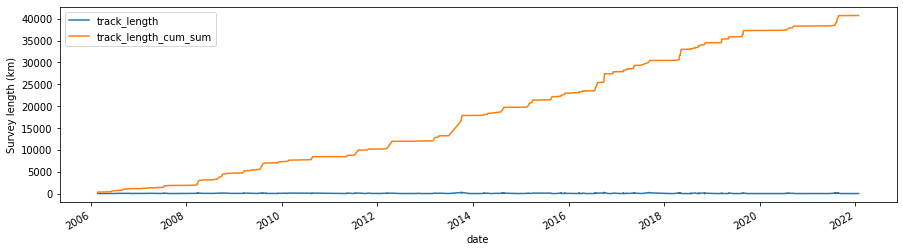

In [6]:
# Plot and export to csv
df.plot(ylabel="Survey length (km)", figsize=(15,4))
df.to_csv("smdb_track_lengths.csv")